In [48]:
import pickle
import argparse
import os
import pandas as pd
import plotting_code
from pathlib import Path
from importlib import reload

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

REVIEWS_TESTING_OUTPUTS_DIR = "../review_model_review_testing_outputs"
SENTENCES_TESTING_OUTPUTS_DIR = "../review_model_sentence_testing_outputs"

%matplotlib notebook
bargraph_savepath = "../review_model_sentence_testing_outputs/plots/reviews_with_negation"
plot_type = "negation_positive_plot"

names_map = {
    "yelp": "Yelp", 
    "imdb": "IMDB", 
    "tripadvisor": "Tripadvisor", 
    "cellphones_and_accessories": "Cellphones", 
    "pet_supplies": "Pet Supplies",
    "automotive": "Automotive", 
    "luxury_beauty": "Luxury Beauty", 
    "sports_and_outdoors": "Sports", 
}

/data/anaconda3/envs/madhu-py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [49]:
def read_and_load_model_outputs(correction_score, label, testing_outputs_dir):
    plot_df = pd.DataFrame()
    for d in list(names_map.keys()):
        if True:
            pos_file = os.path.join(testing_outputs_dir, d, "pos_sents_test")        
            neg_file = os.path.join(testing_outputs_dir, d, "neg_sents_test")

            data_pos = pickle.load(open(pos_file, "rb"))
            data_neg = pickle.load(open(neg_file, "rb"))

            pos_file_review_testing = os.path.join(REVIEW_TESTING_DIR, d, "pos_reviews_test")        
            neg_file_review_testing = os.path.join(REVIEW_TESTING_DIR, d, "neg_reviews_test")
            
            data_pos_review_testing = pickle.load(open(pos_file_review_testing, "rb"))
            data_neg_review_testing = pickle.load(open(neg_file_review_testing, "rb"))
            
            dataset_name = data_pos["name"].to_list()[0]
            if plot_type == "normal_plot":
                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "review_category": "positive",
                    "accuracy": data_pos["accuracy"].to_list()[0]*100,
                }, ignore_index=True)

                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "review_category": "negative",
                    "accuracy": data_neg["accuracy"].to_list()[0]*100,
                }, ignore_index=True)
            elif plot_type == "negation_positive_plot":
                if label == "positive":
                    data_df_plot = data_pos
                    data_df_plot_review_testing = data_pos_review_testing
                else:
                    data_df_plot = data_neg
                    data_df_plot_review_testing = data_neg_review_testing

                if correction_score == True:
                    correct_count = data_df_plot_review_testing["correct_count"].to_list()[0]
                    total_count = data_df_plot_review_testing["total_count"].to_list()[0]
                    accuracy = data_df_plot["accuracy"].to_list()[0]
                    true_rate = correct_count/total_count
                    false_rate = (total_count-correct_count)/total_count
                    acc = true_rate*accuracy + false_rate*(1-accuracy)
                else:                    
                    acc = data_df_plot["correct_count"].to_list()[0]/data_df_plot["total_count"].to_list()[0]

                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "category": "all sentences",
                    "accuracy": acc*100,
                }, ignore_index=True)

                acc = data_df_plot["correct_count_with_negation"].to_list()[0]/data_df_plot["total_negation_count"].to_list()[0]
                if correction_score == True:
                    # accuracy = data_df_plot["accuracy"].to_list()[0]
                    true_rate = data_df_plot_review_testing["correct_count_with_negation"].to_list()[0]/ \
                        data_df_plot_review_testing["total_negation_count"].to_list()[0]
                    false_rate = data_df_plot_review_testing["incorrect_count_with_negation"].to_list()[0]/ \
                        data_df_plot_review_testing["total_negation_count"].to_list()[0]
                    acc = true_rate*acc + false_rate*(1-acc)


                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "category": "sentences with negation",
                    "accuracy": acc*100,
                }, ignore_index=True)

                acc = data_df_plot["correct_count_with_pos_words"].to_list()[0]/data_df_plot["total_count_with_pos_words"].to_list()[0]
                if correction_score == True:                    
                    true_rate = data_df_plot_review_testing["correct_count_with_pos_words"].to_list()[0]/ \
                        data_df_plot_review_testing["total_count_with_pos_words"].to_list()[0]
                    false_rate = data_df_plot_review_testing["incorrect_count_with_pos_words"].to_list()[0]/ \
                        data_df_plot_review_testing["total_count_with_pos_words"].to_list()[0]
                    acc = true_rate*acc + false_rate*(1-acc)


                plot_df = plot_df.append({
                    "name": names_map[dataset_name],
                    "category": "sentences with positive lexicons",
                    "accuracy": acc*100,
                }, ignore_index=True)


    amazon_names = ['Pet Supplies', 'Luxury Beauty', 'Automotive', 'Cellphones', 'Sports']
    amazon_names = [val for val in amazon_names]   
    if plot_type == "normal_plot":
        colors = [(84/255, 141/255, 255/255),  (84/255, 141/255, 255/255)]*2
    elif plot_type == "negation_positive_plot":
        colors = [(183/255, 183/255, 183/255),(67/255, 144/255, 188/255), (2/255, 72/255, 110/255)]*2

    Path(os.path.join(testing_outputs_dir, "df_outputs")).mkdir(parents=True, exist_ok=True)
    plot_df.to_csv(os.path.join(testing_outputs_dir, "df_outputs",
        'df_outputs_correction_'+str(correction_score)+'_'+plot_type+'_'+label+'_reviews.csv') )


    plot_df_amz = plot_df[plot_df["name"].isin(amazon_names)]
    plot_df_non_amz = plot_df[~plot_df["name"].isin(amazon_names)]

    if label == 'positive':
        y_axis_name = "\% of pos. sentences"
    else:
        y_axis_name = "\% of neg. sentences"

    ylim_top = plot_df_amz.max(axis=0)["accuracy"]
    ylim_top = 1.7*ylim_top

    Path(os.path.dirname(bargraph_savepath)).mkdir(parents=True, exist_ok=True)

    if correction_score:
        save_path = bargraph_savepath+"_"+ label+"_reviews_with_correction"
    else:
        save_path = bargraph_savepath+"_"+ label+"_reviews"

    ylim_top = plot_df_non_amz.max(axis=0)["accuracy"]
    ylim_top = 1.7*ylim_top


Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_amz


<IPython.core.display.Javascript object>


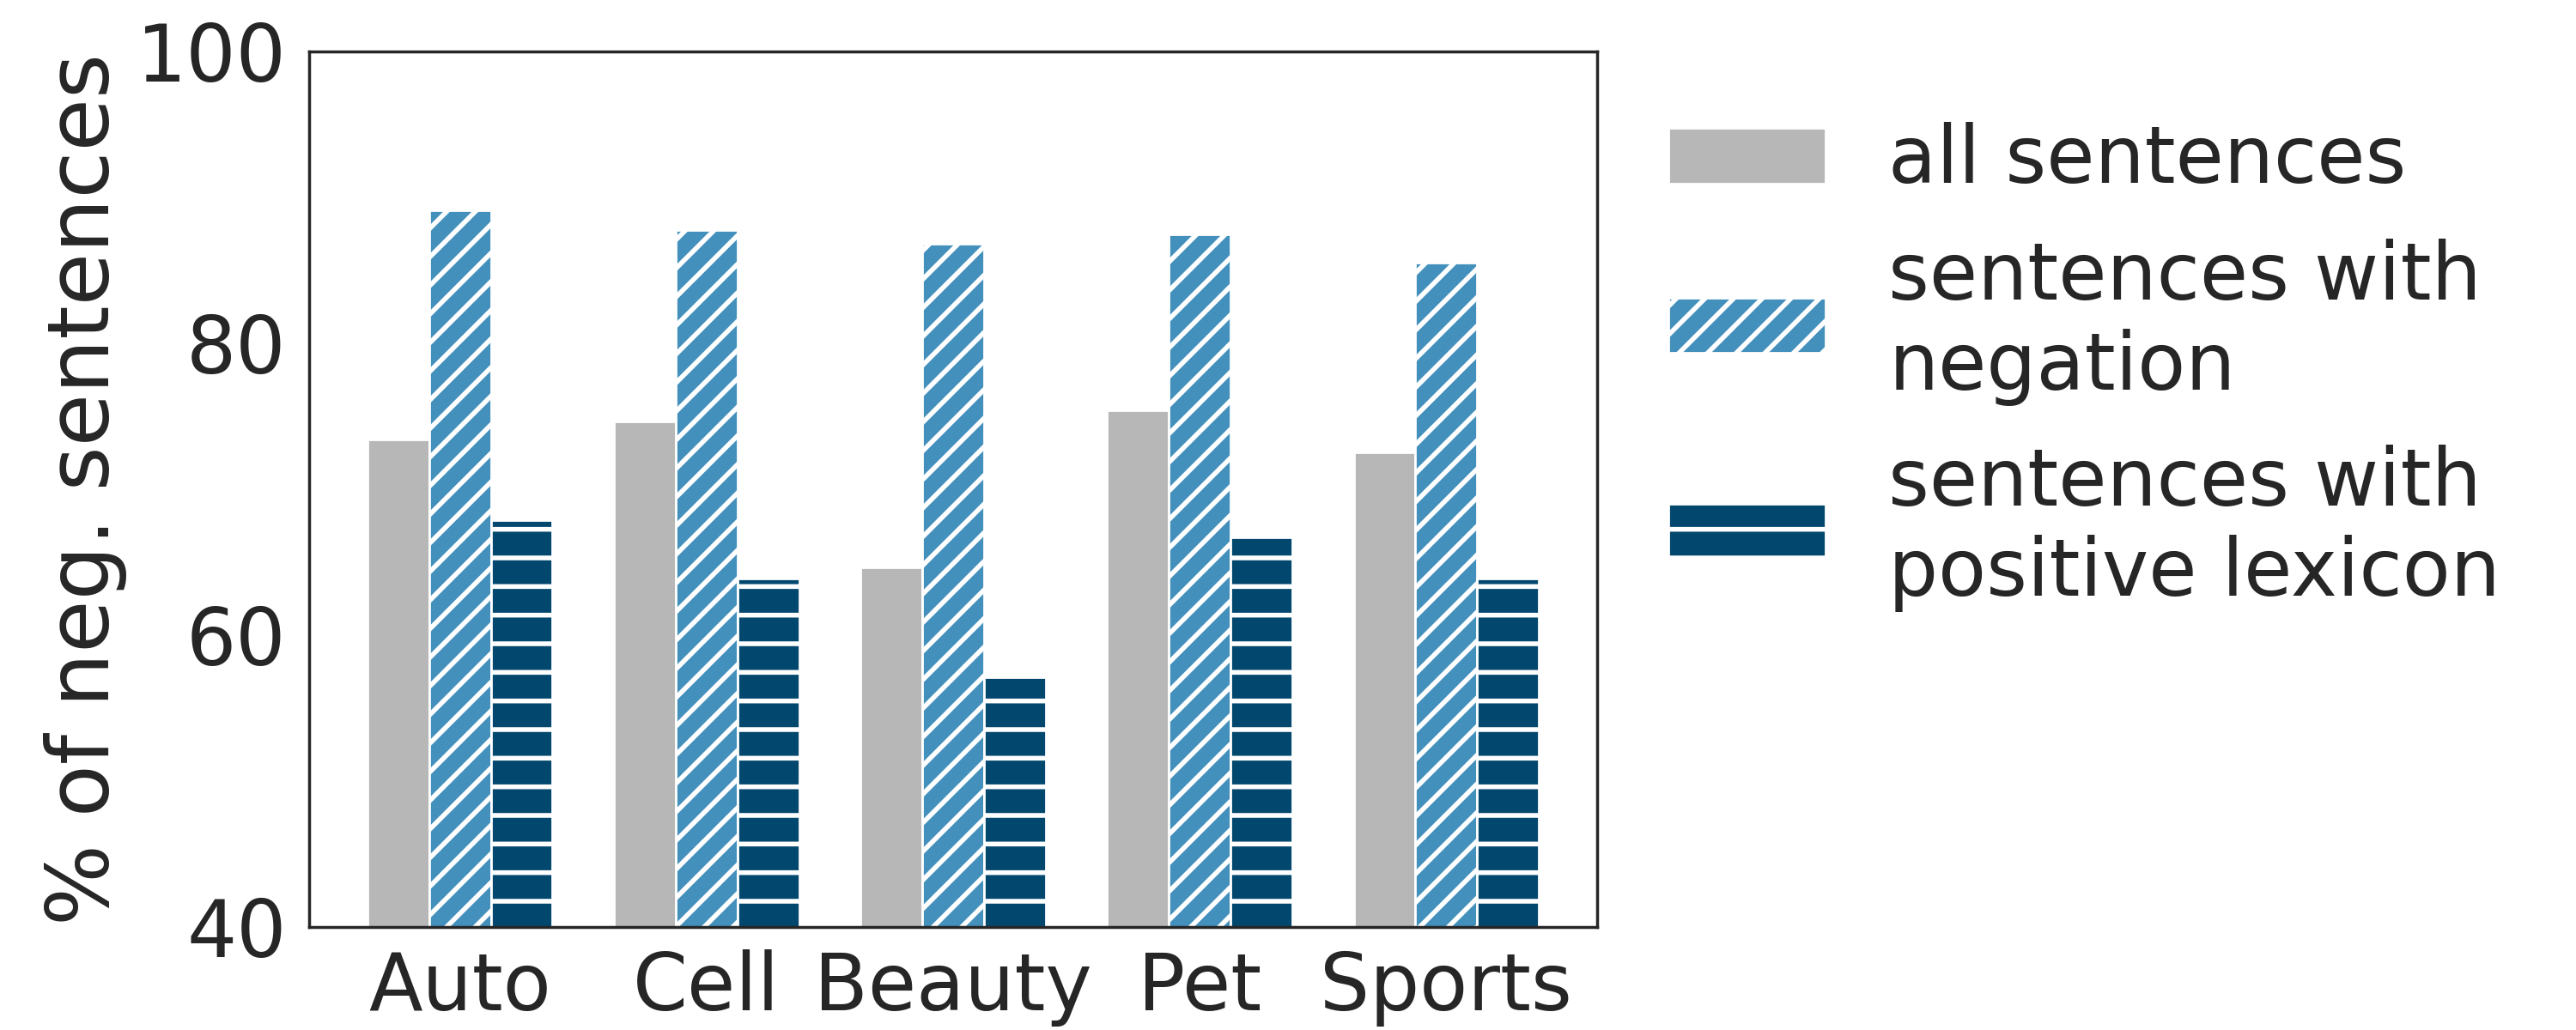

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_non_amz


<IPython.core.display.Javascript object>


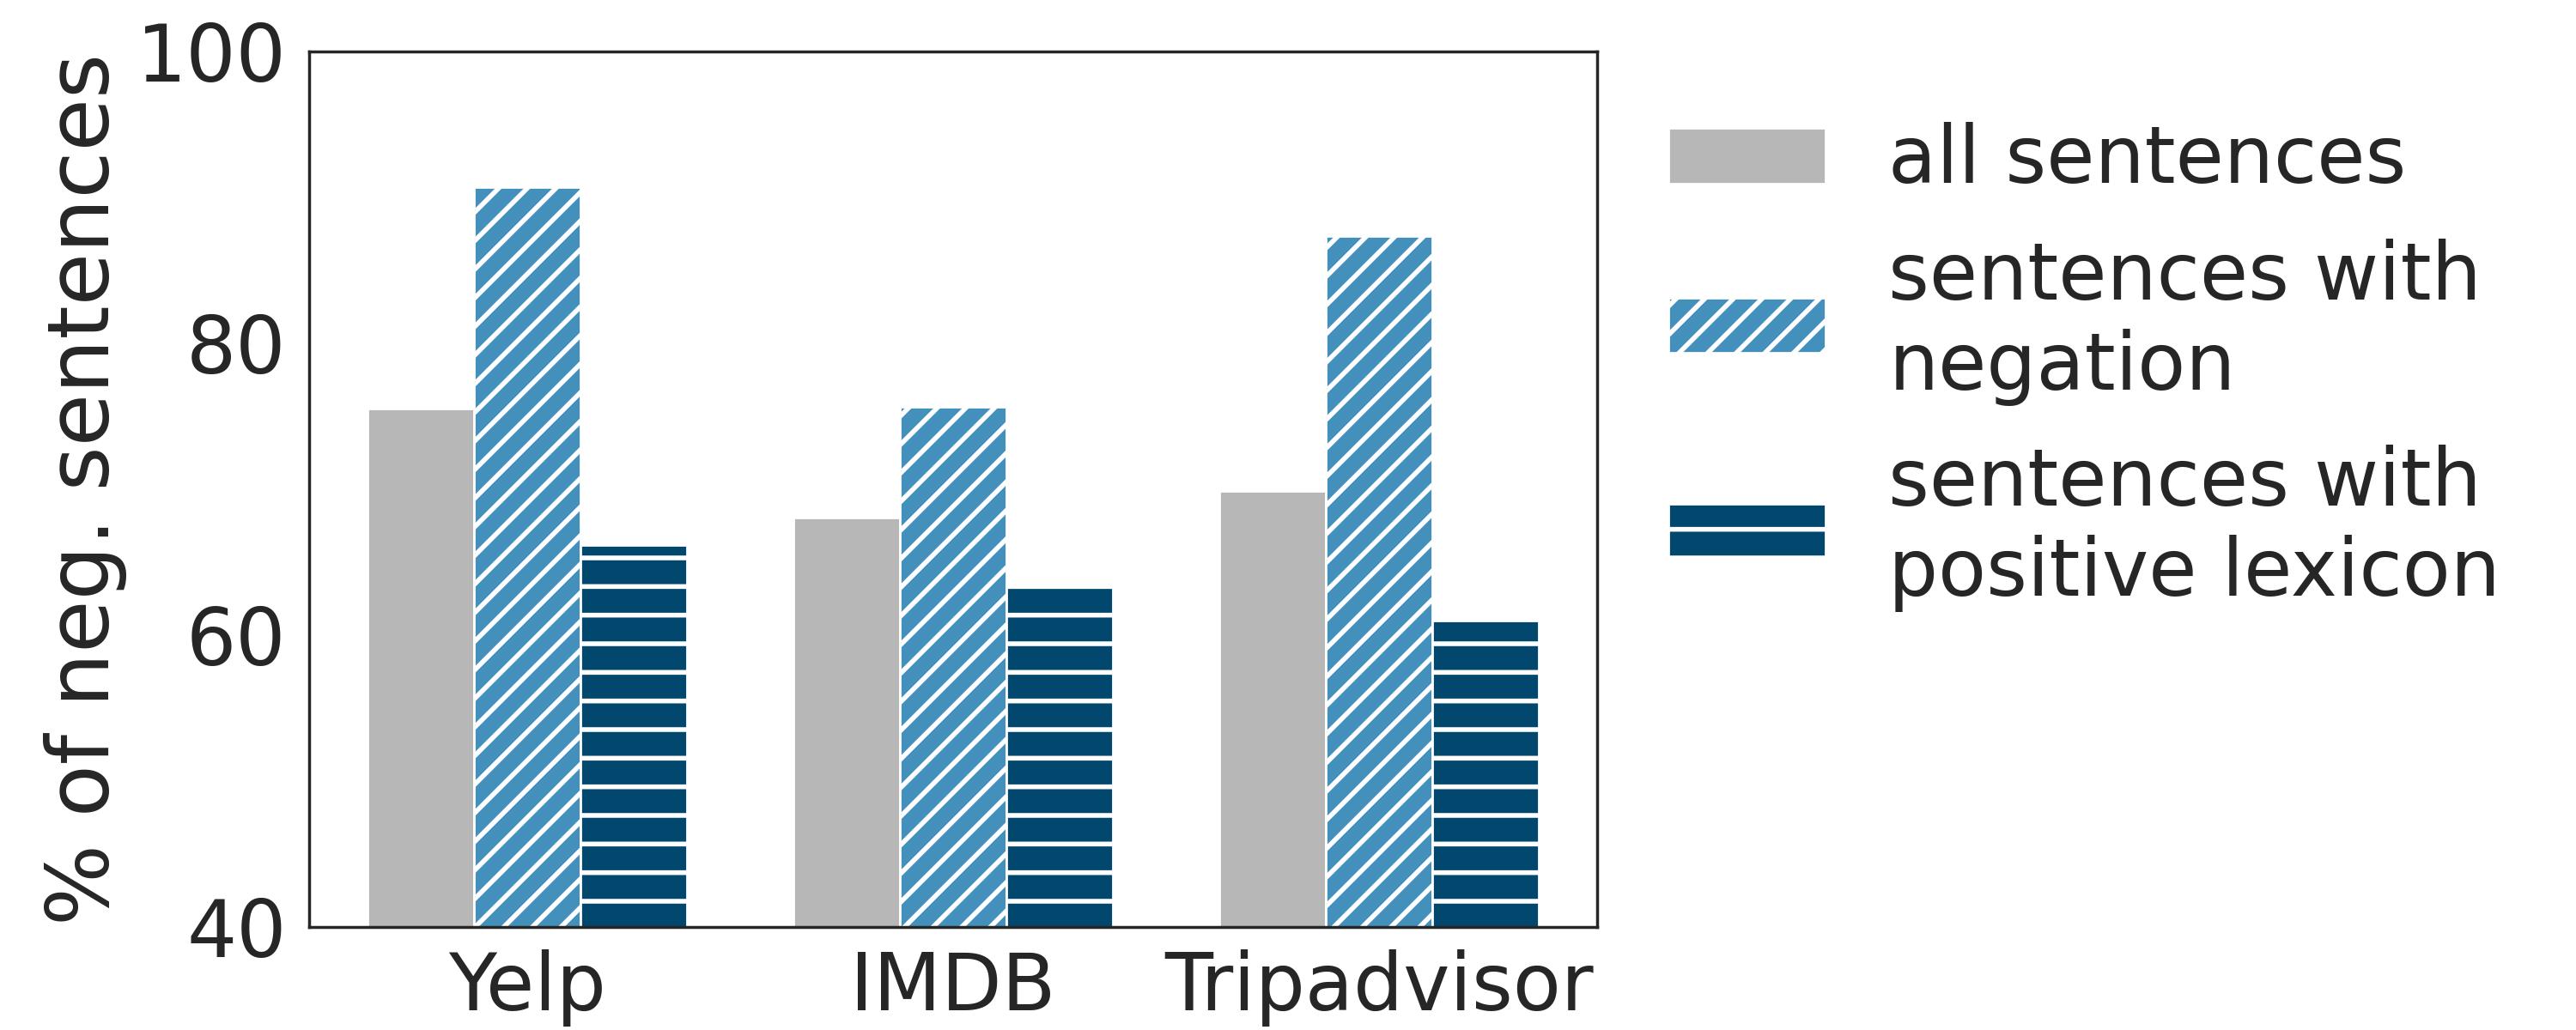

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_amz


<IPython.core.display.Javascript object>


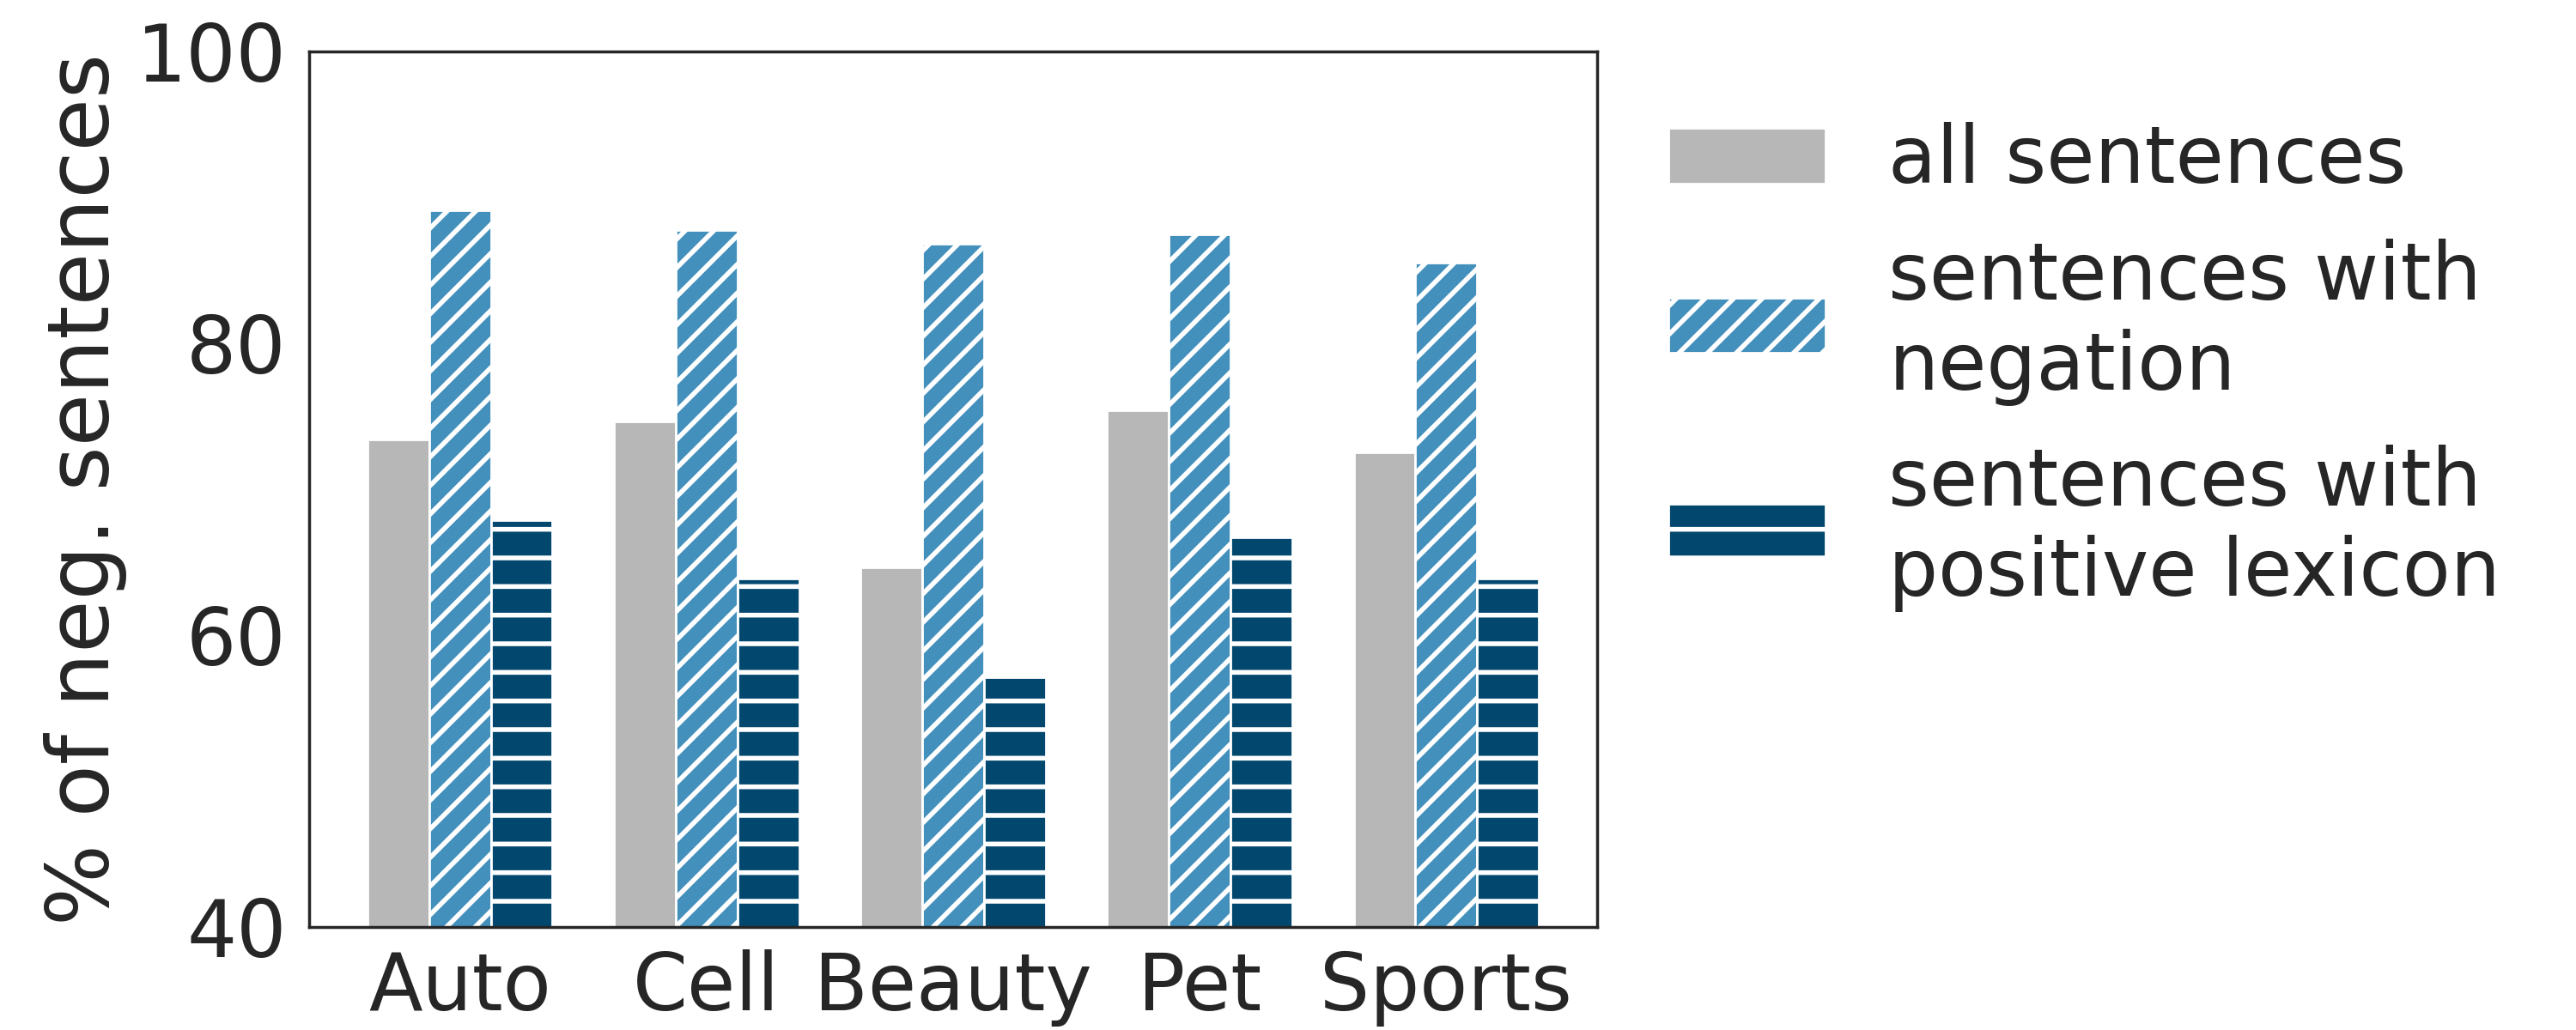

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_non_amz


<IPython.core.display.Javascript object>


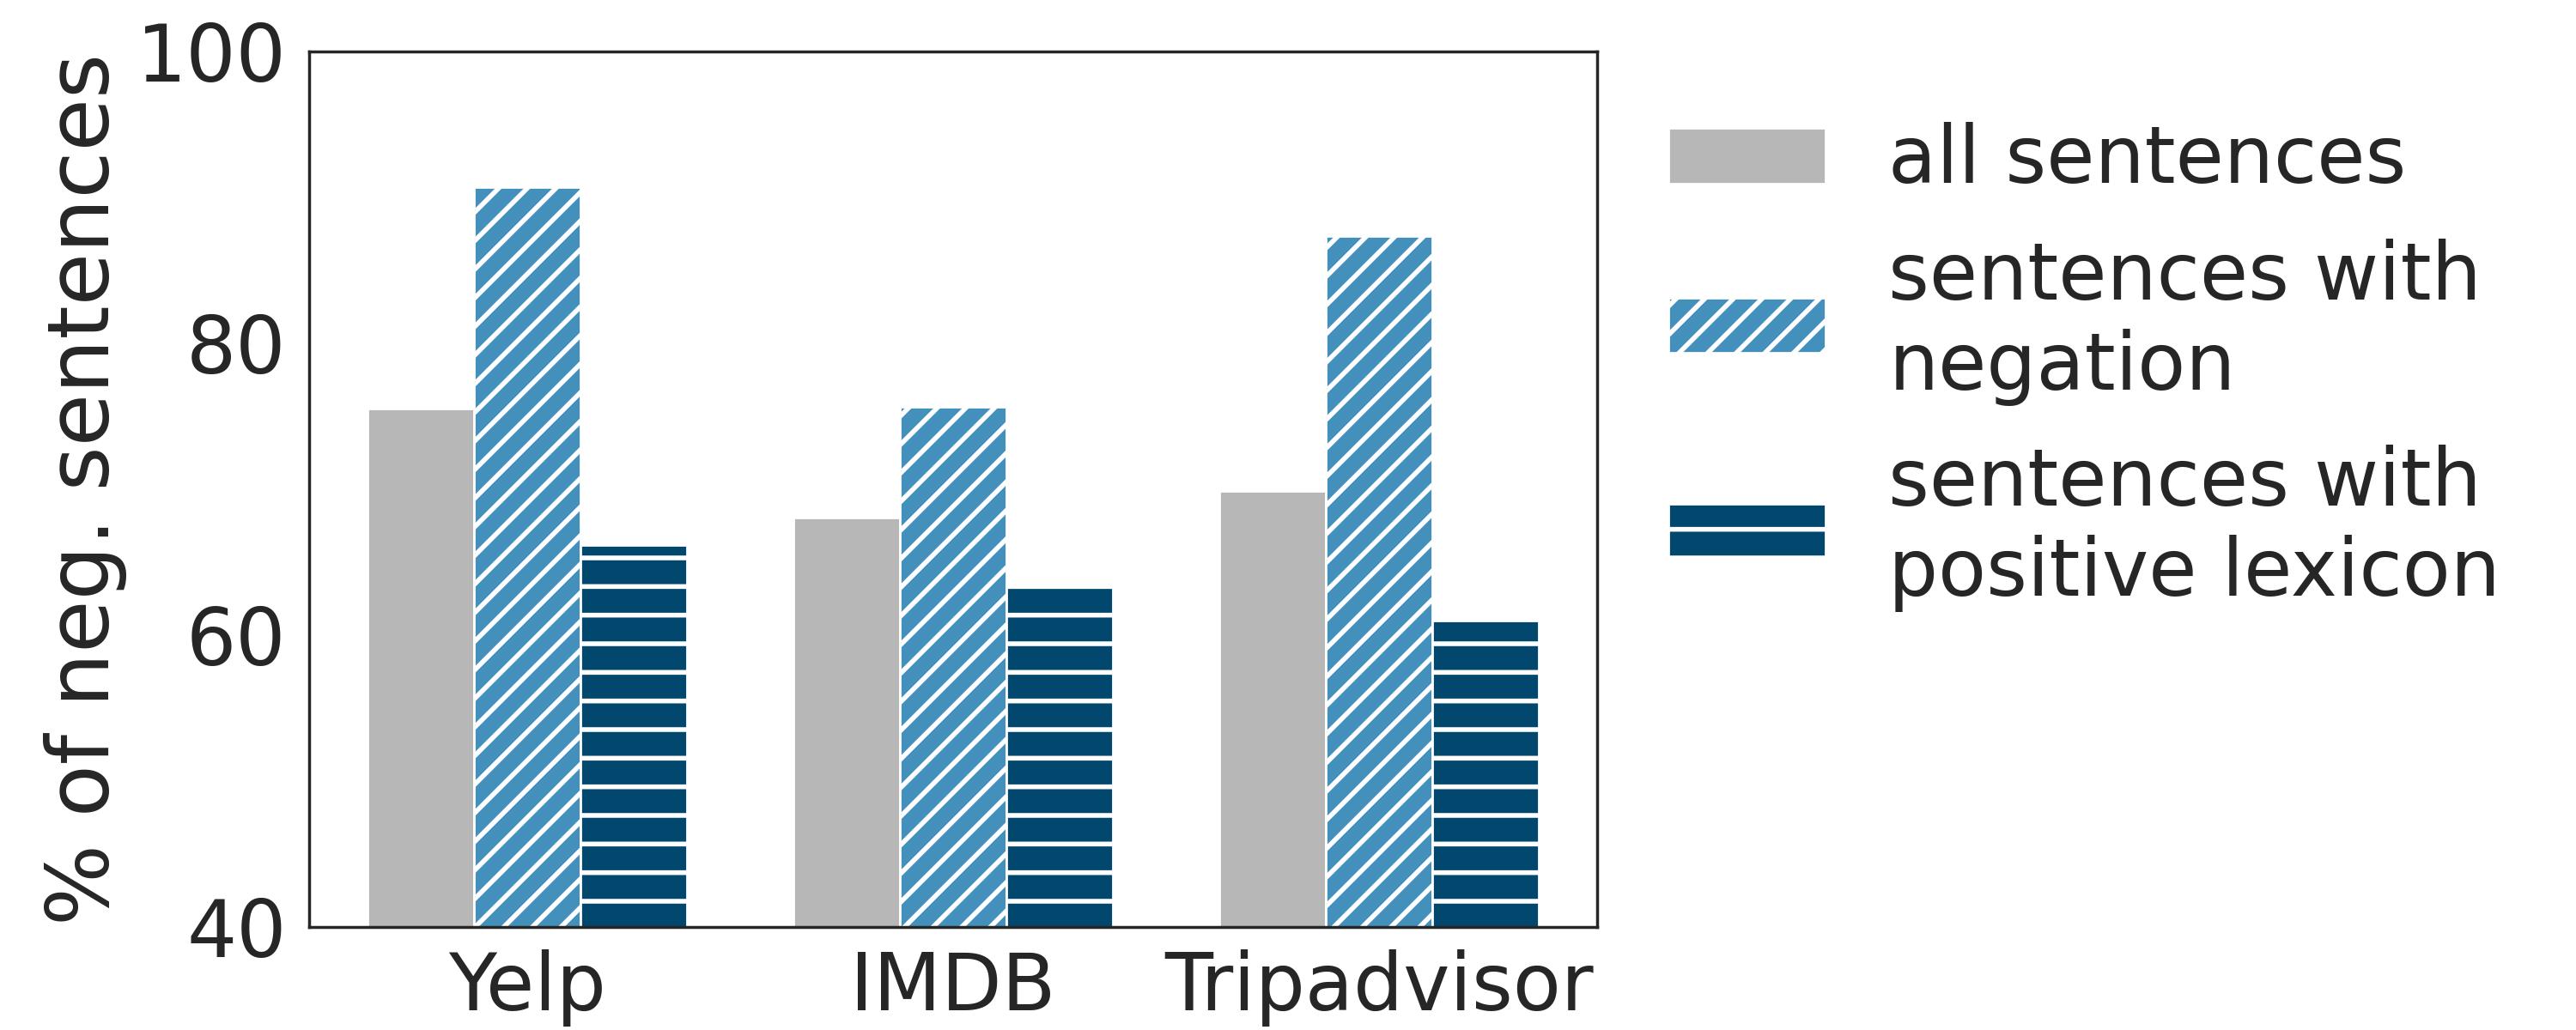

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_amz


<IPython.core.display.Javascript object>


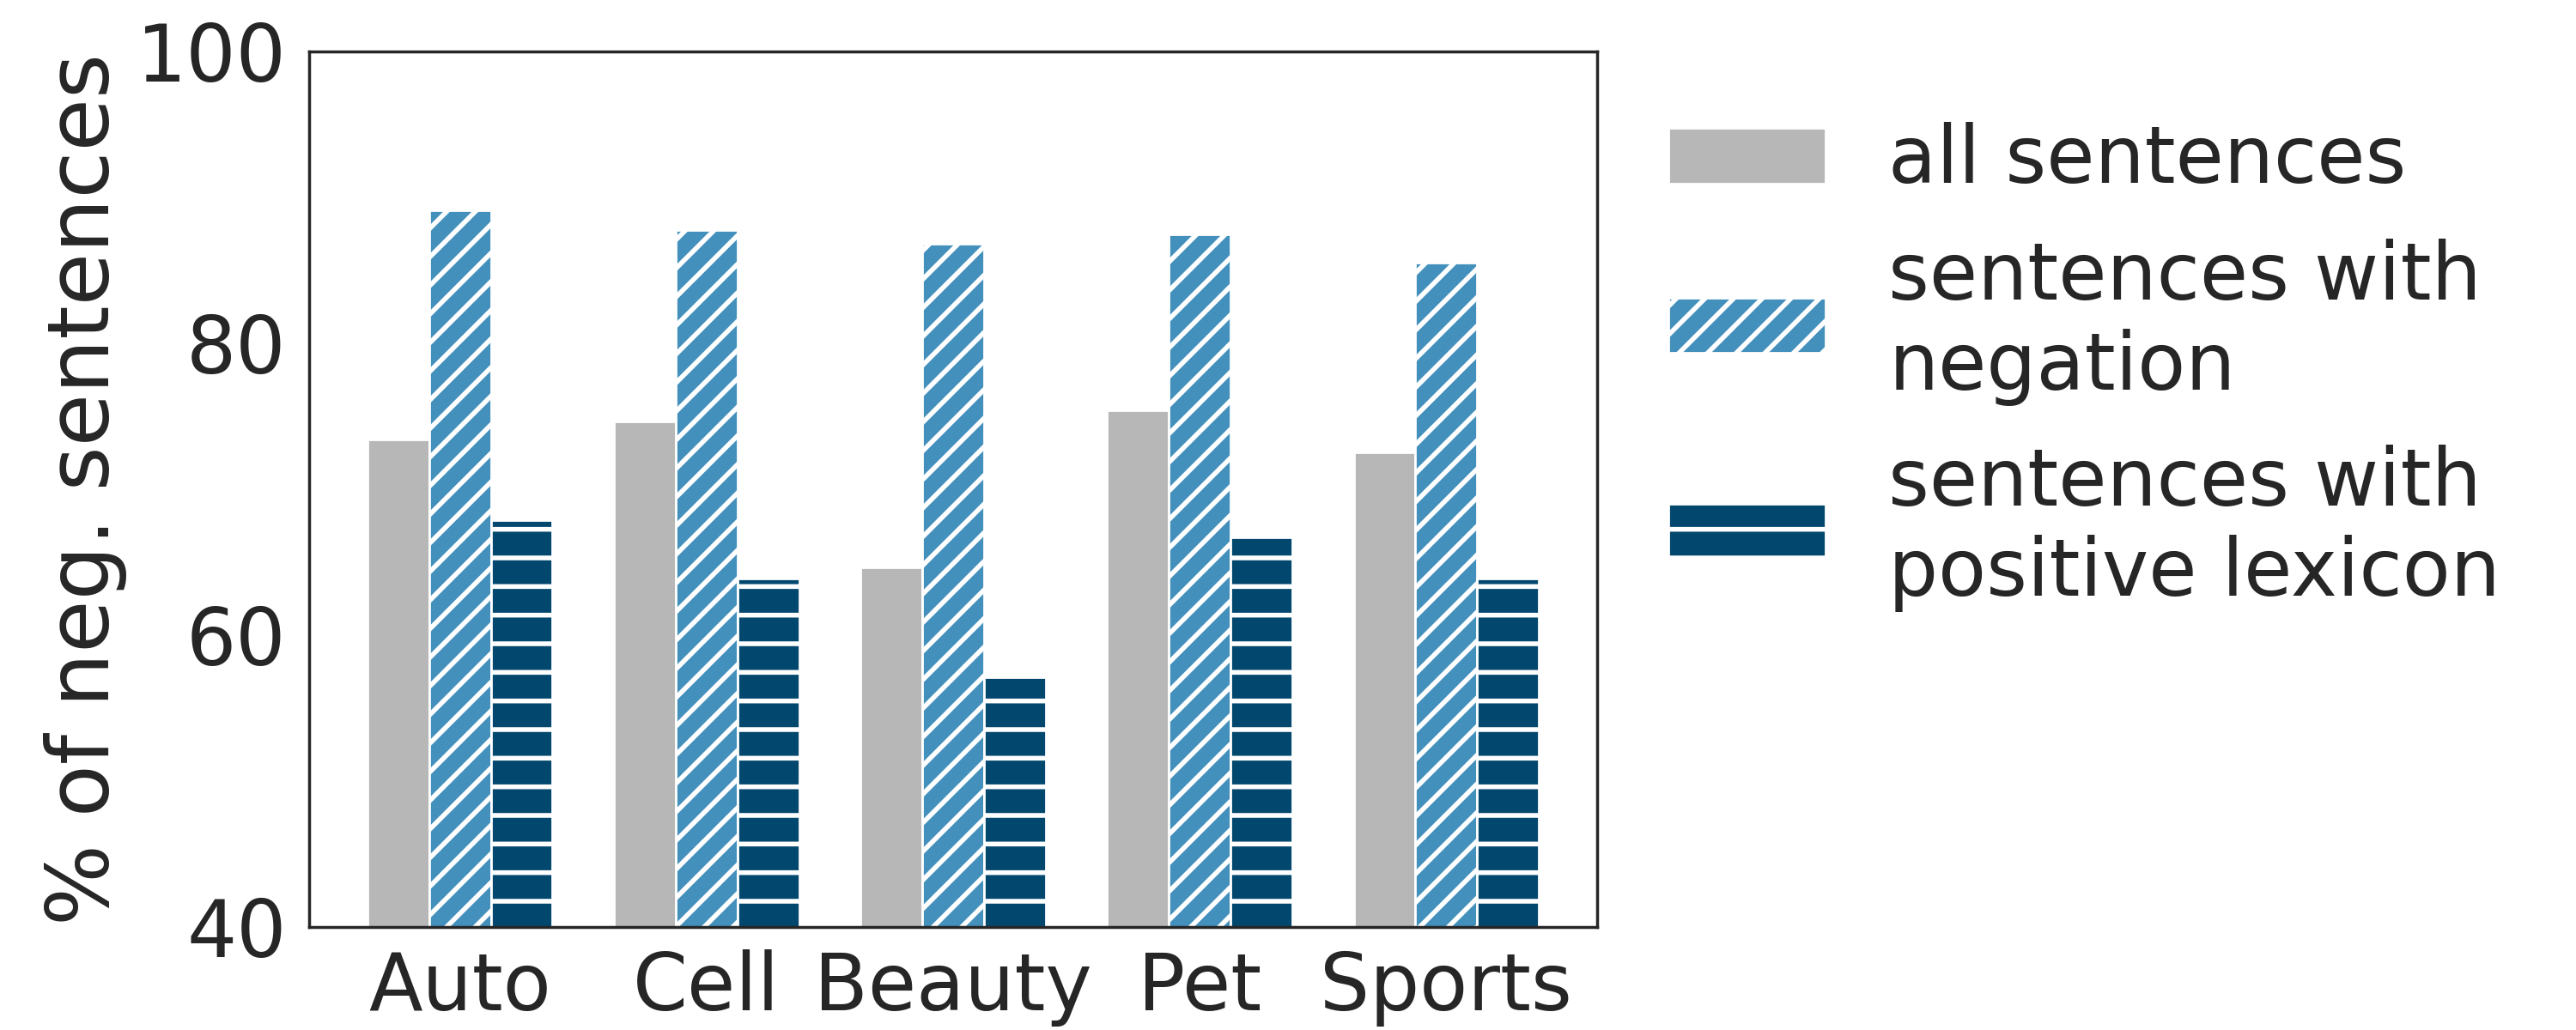

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_non_amz


<IPython.core.display.Javascript object>


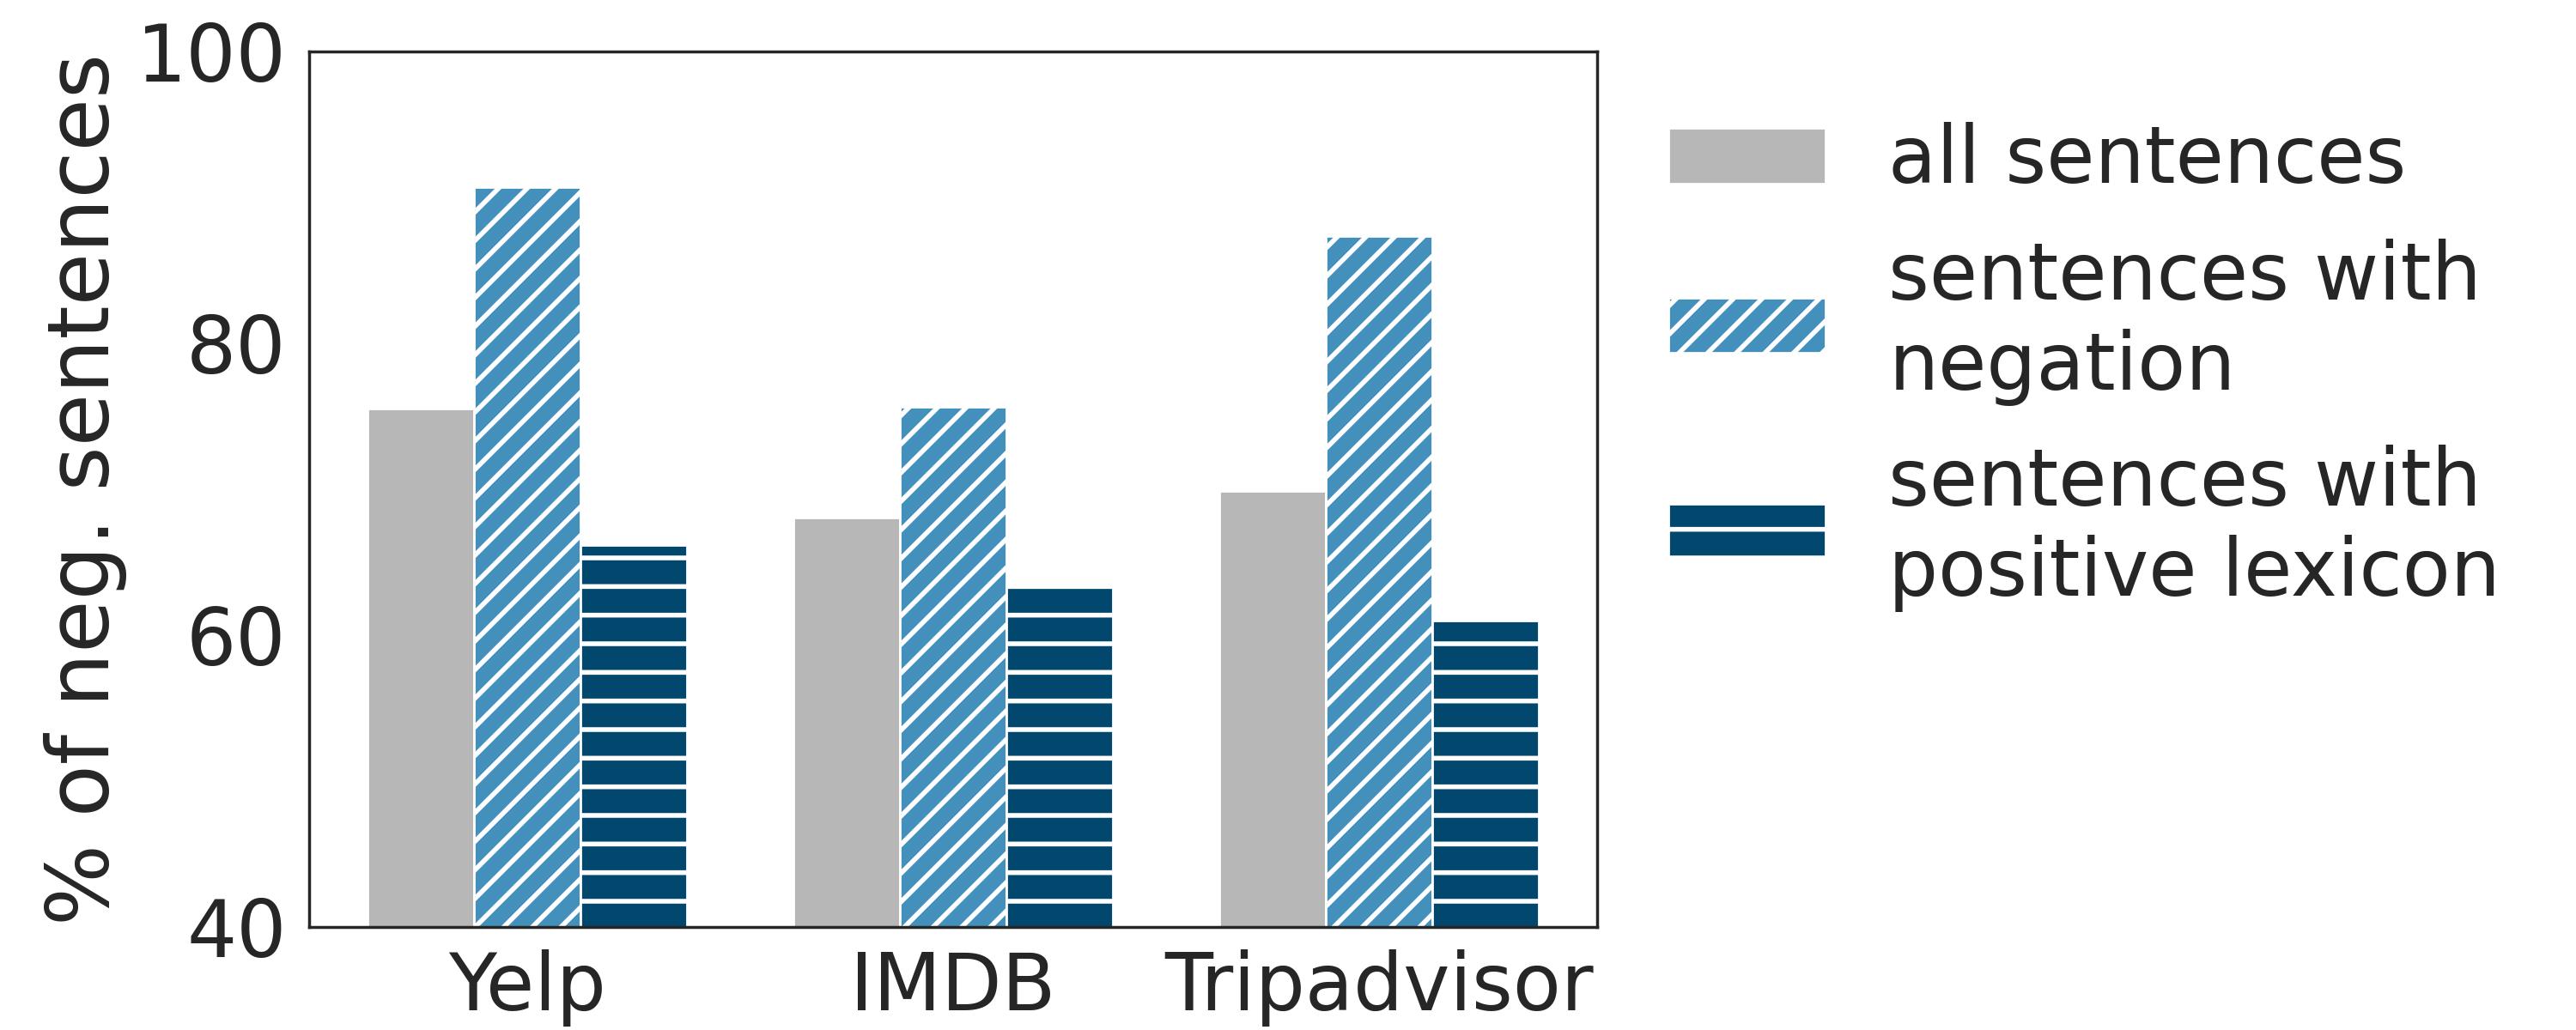

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_amz


<IPython.core.display.Javascript object>


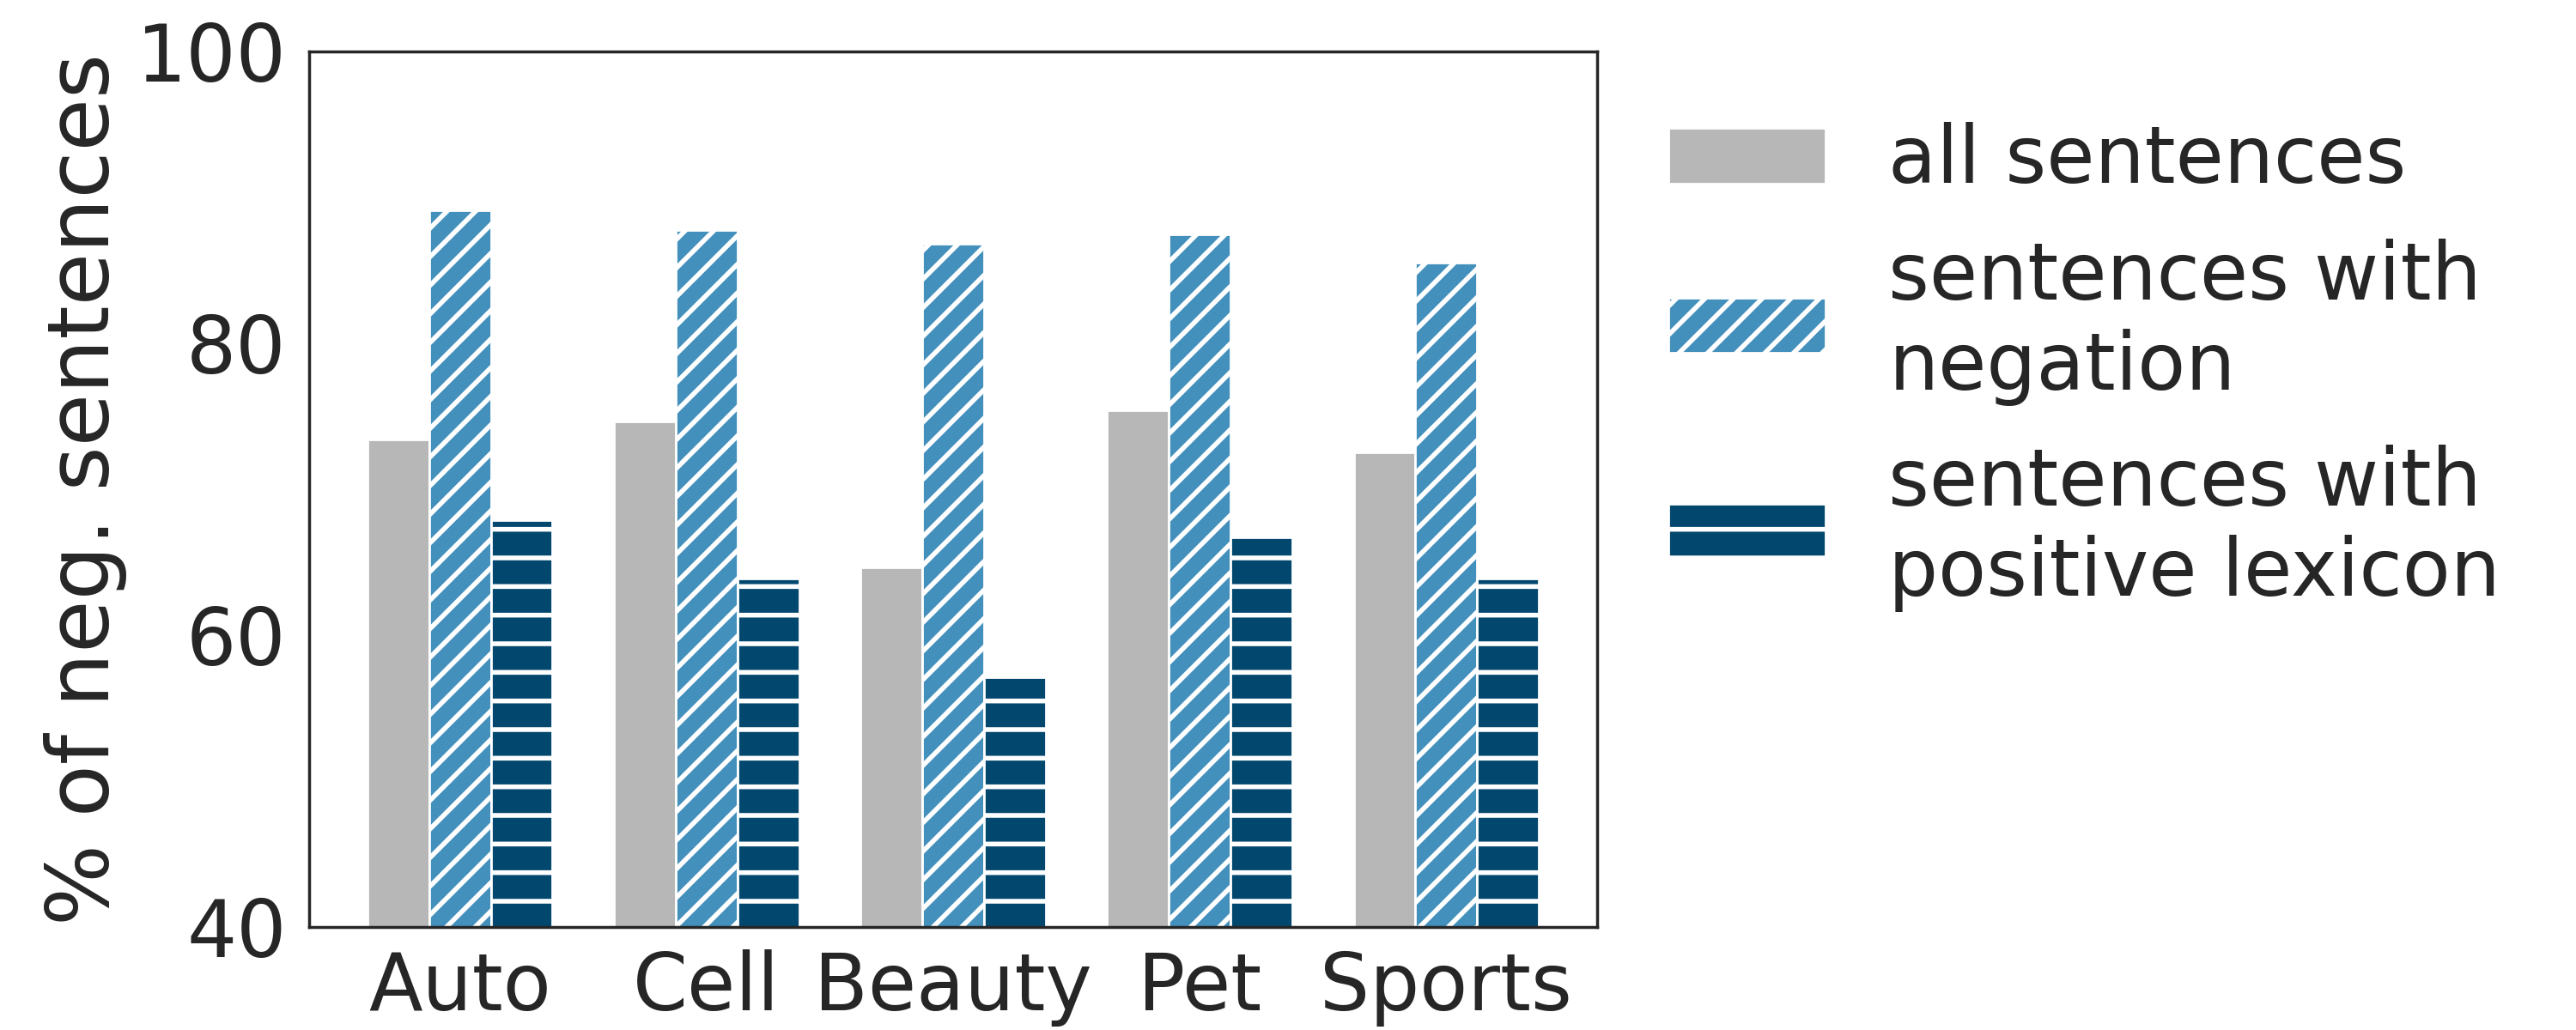

Saving the plot in  ../review_model_sentence_testing_outputs/plots/reviews_with_negation_negative_reviews_with_correction_non_amz


<IPython.core.display.Javascript object>


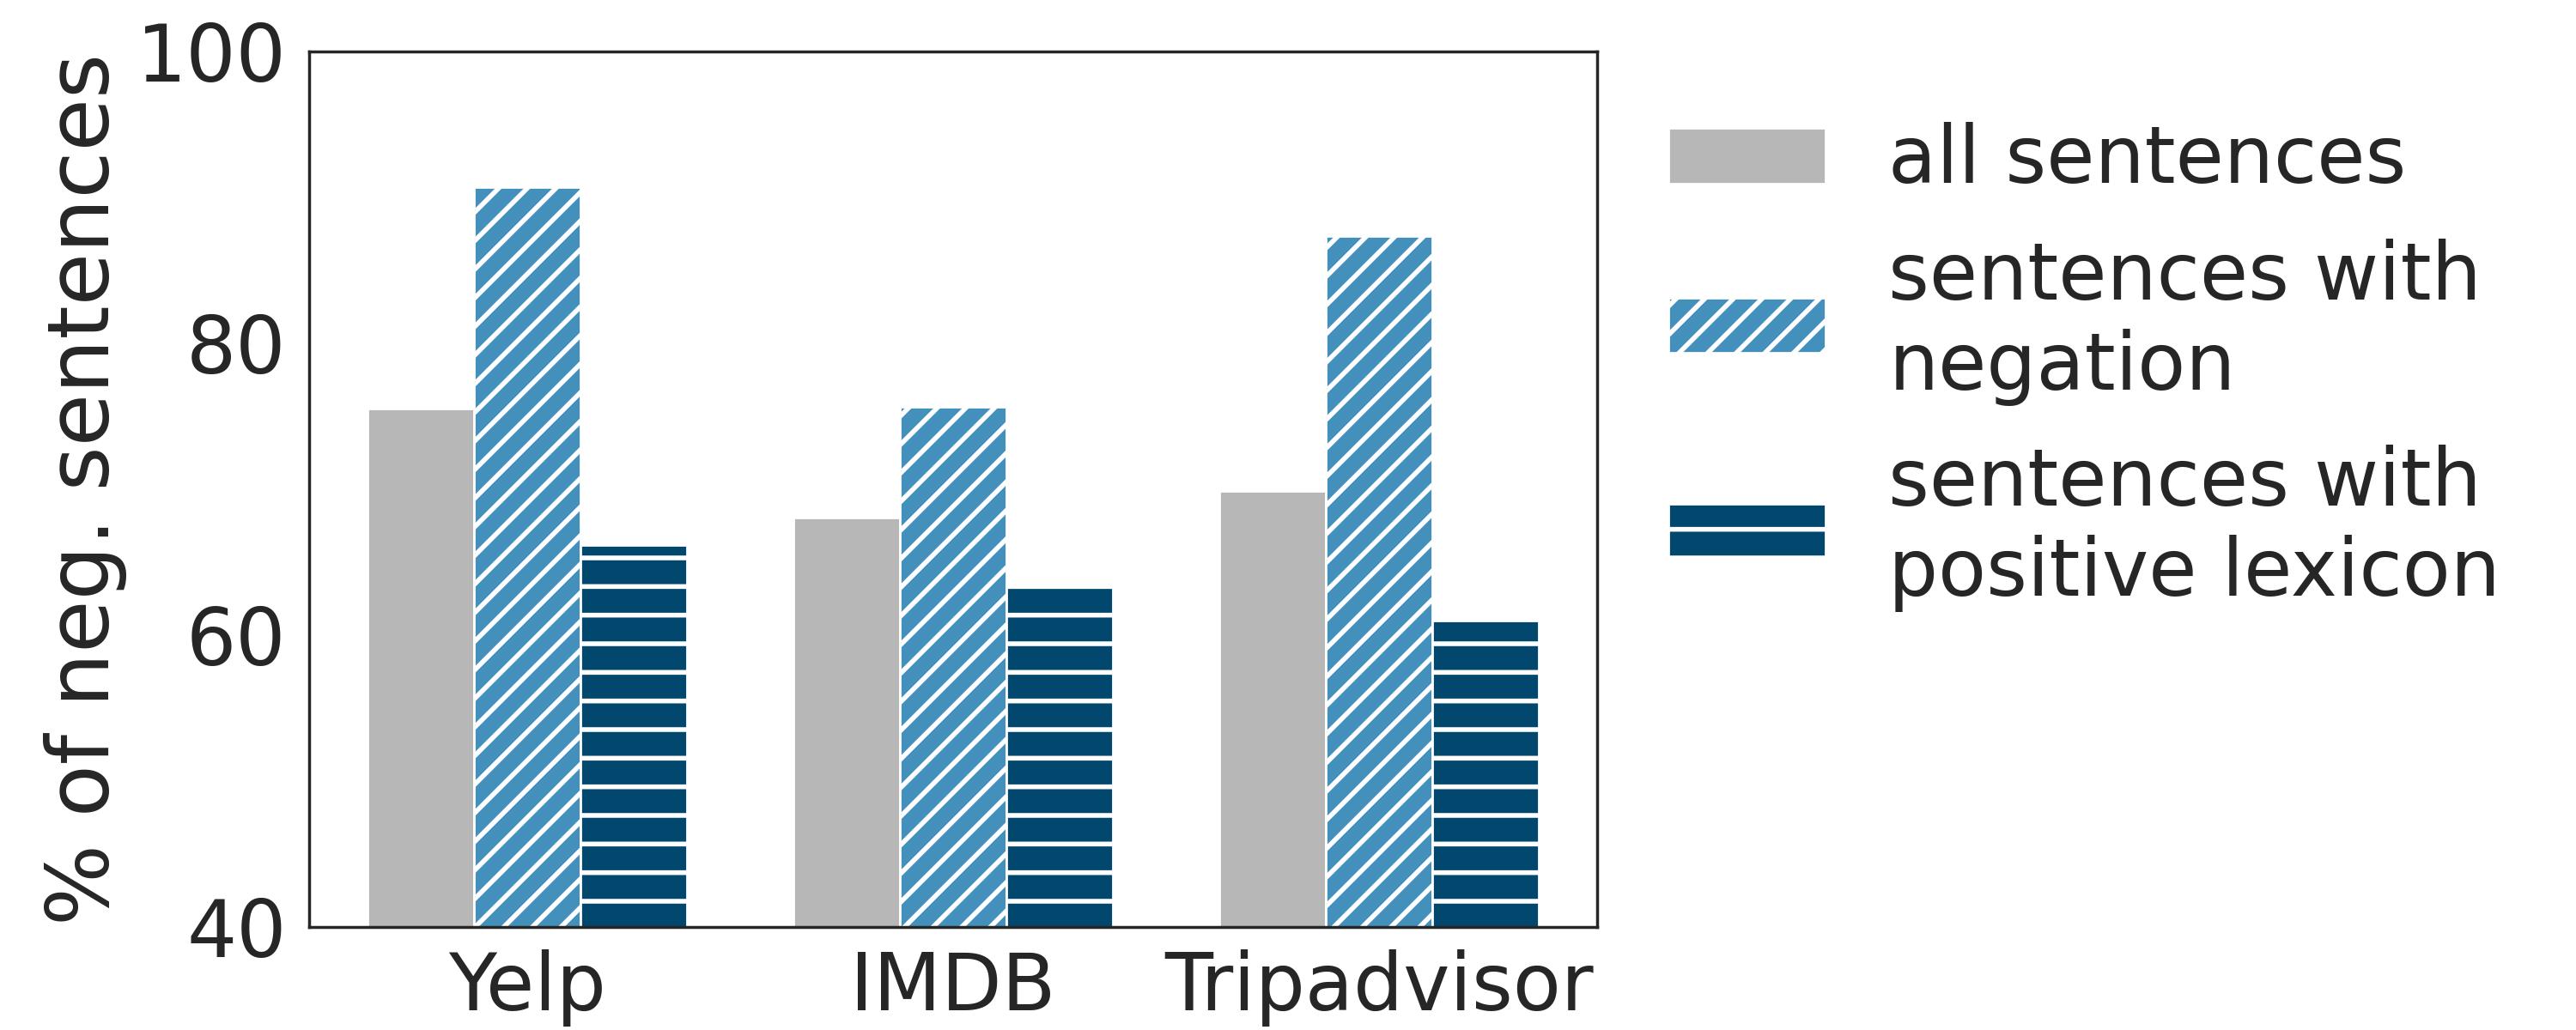

In [51]:
reload(plotting_code)

for label in ["negative", "positive"]:
    for correction_score in [True, False]:
        read_and_load_model_outputs(correction_score, label, SENTENCES_TESTING_OUTPUTS_DIR)
        plotting_code.draw_grouped_barplot_three_subbars(plot_df_amz, colors, "name", "accuracy", 
                                                        "category", save_path+"_amz", 
                                                         y_axis_name="% of neg. sentences",
                                                        figsize=(15,6), position=(0.12,0.1,0.5,0.85),
                                                        bbox_to_anchor=(1, 0.5, 0.2, 0.5),
                                                        amazon_data_flag=True)
        plotting_code.draw_grouped_barplot_three_subbars(plot_df_non_amz, colors, "name", "accuracy", 
                                                        "category", save_path+"_non_amz", 
                                                         y_axis_name="% of neg. sentences",
                                                        figsize=(15,6), position=(0.12,0.1,0.5,0.85),
                                                        bbox_to_anchor=(1, 0.5, 0.2, 0.5),
                                                        amazon_data_flag=False)